In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from jiahao_funcs import *

# Data and preproces

In [3]:
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)
print('-------------- Dataset original --------------')
print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))
data = preprocess_entity_recognition(train_data, val_data, test_data, num_words=500)
print('-------------- Dataset preprocesado entity recognition --------------')
print('Vocab size:', data['vocab_size'])
print('Maxlen:', data['maxlen'])
print('Num classes:', data['num_classes'])
print(data["train_X"].shape, data["train_y"].shape)
print(data["val_X"].shape, data["val_y"].shape)
print(data["test_X"].shape, data["test_y"].shape)


-------------- Dataset original --------------
Training size: 4078
Validation dataset size: 900
Test dataset size: 893
-------------- Dataset preprocesado entity recognition --------------
Vocab size: 831
Maxlen: 46
Num classes: 119
(4078, 46) (4078, 46, 119)
(897, 46) (897, 46, 119)
(885, 46) (885, 46, 119)


# Probar num_words

In [4]:
# Max_vocab_size = 830
def model_build(num_classes, vocab_size, maxlen, embedding_dim = 256, num_head = 4, ff_dim = 256):
    model = Sequential()
    model.add(TokenAndPositionEmbedding(maxlen, vocab_size, embedding_dim))
    model.add(TransformerBlock(embedding_dim, num_head, ff_dim))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))
    return model
results = provar_num_words(model_build, preprocess=preprocess_entity_recognition, train_data=train_data, val_data=val_data, test_data=test_data,
                          num_words_list=[i for i in range(50, 851, 200)],
                          batch_size=32, epochs=30, patience=5, runs=1)

-------Running num_words=50  (1 runs)...---------

  run 1/1 done | last val_loss=0.1620
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Finished num_words=50  |  averaged last val_loss=0.1620
-------Running num_words=250  (1 runs)...---------


KeyboardInterrupt: 

Respecto a la evolucion de la loss, observamos que la principal diferencia está entre utilizar un num_words de 100, 200 y 300 o más. Aunque es menos pronunciado, pasa la mismo con la f1-score. De hecho, en cuanto al f1-score el valor 300 obtiene el mejor o muy igualado al mejor (valor de 400) rendimiento respecto a los datos de validación. Por lo tanto, podria ser el mejor en la relacion entre rendimiento i menor valor. Sin embargo, procedemos ha repetir el experimento pero con valores entre 100 y 300 para analizar con mayor detalle.

-------Running num_words=100  (5 runs)...---------


C:\Users\jiaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  run 1/5 done | last val_loss=1.2444
  run 2/5 done | last val_loss=1.2318
  run 3/5 done | last val_loss=1.1749
  run 4/5 done | last val_loss=1.2221
  run 5/5 done | last val_loss=1.2771
Finished num_words=100  |  averaged last val_loss=1.1749
-------Running num_words=150  (5 runs)...---------


C:\Users\jiaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  run 1/5 done | last val_loss=1.1754
  run 2/5 done | last val_loss=1.0420
  run 3/5 done | last val_loss=1.0701
  run 4/5 done | last val_loss=1.0984
  run 5/5 done | last val_loss=1.0899
Finished num_words=150  |  averaged last val_loss=1.0941
-------Running num_words=200  (5 runs)...---------


C:\Users\jiaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  run 1/5 done | last val_loss=1.0651
  run 2/5 done | last val_loss=1.0520
  run 3/5 done | last val_loss=0.9836
  run 4/5 done | last val_loss=0.9889
  run 5/5 done | last val_loss=0.9388
Finished num_words=200  |  averaged last val_loss=0.9388
-------Running num_words=250  (5 runs)...---------


C:\Users\jiaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  run 1/5 done | last val_loss=0.9434
  run 2/5 done | last val_loss=0.9270
  run 3/5 done | last val_loss=0.9188
  run 4/5 done | last val_loss=1.0261
  run 5/5 done | last val_loss=0.8198
Finished num_words=250  |  averaged last val_loss=0.9434
-------Running num_words=300  (5 runs)...---------


C:\Users\jiaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  run 1/5 done | last val_loss=0.7600
  run 2/5 done | last val_loss=0.7643
  run 3/5 done | last val_loss=0.7978
  run 4/5 done | last val_loss=0.7967
  run 5/5 done | last val_loss=0.6863
Finished num_words=300  |  averaged last val_loss=0.7784


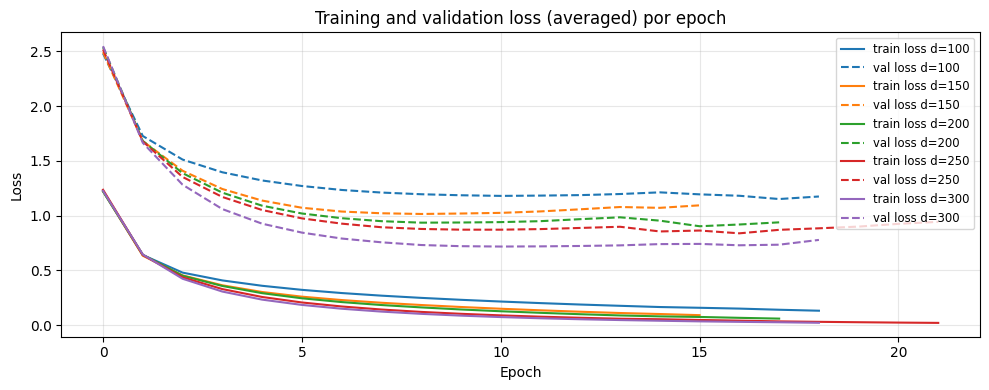

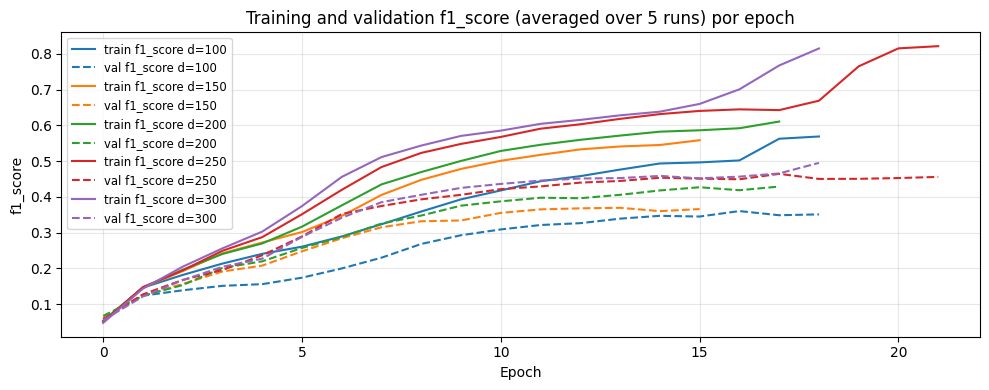

In [5]:
results = provar_num_words(model_build, preprocess=preprocess_intent_recognition, train_data=train_data, val_data=val_data, test_data=test_data,
                          num_words_list=[i for i in range(100, 301, 50)], batch_size=32, epochs=30, patience=5, runs=5)

En este zoom observamos el comportamiento esperado (cuanto mayor es el valor mejor es el rendimiento) tanto en la loss como en el f1-score. En consecuencia, podemos escoger el valor 300 para num_words en futuros experimentos.

In [6]:
data_intent_recognition = preprocess_intent_recognition(train_data, val_data, test_data, num_words=300)

# Embeddings

-------Running embedding_dim=32  (5 runs)...---------


C:\Users\jiaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  run 1/5 done | last val_loss=0.9885
  run 2/5 done | last val_loss=0.9486
  run 3/5 done | last val_loss=0.9518
  run 4/5 done | last val_loss=0.9239
  run 5/5 done | last val_loss=0.8033
Finished embedding_dim=32  |  averaged last val_loss=0.8033
-------Running embedding_dim=64  (5 runs)...---------
  run 1/5 done | last val_loss=0.8086
  run 2/5 done | last val_loss=0.8381
  run 3/5 done | last val_loss=0.8304
  run 4/5 done | last val_loss=0.8290
  run 5/5 done | last val_loss=0.7687
Finished embedding_dim=64  |  averaged last val_loss=0.7687
-------Running embedding_dim=128  (5 runs)...---------
  run 1/5 done | last val_loss=0.7702
  run 2/5 done | last val_loss=0.7861
  run 3/5 done | last val_loss=0.7320
  run 4/5 done | last val_loss=0.7459
  run 5/5 done | last val_loss=0.6755
Finished embedding_dim=128  |  averaged last val_loss=0.6755
-------Running embedding_dim=256  (5 runs)...---------
  run 1/5 done | last val_loss=0.7678
  run 2/5 done | last val_loss=0.8228
  run 3/5

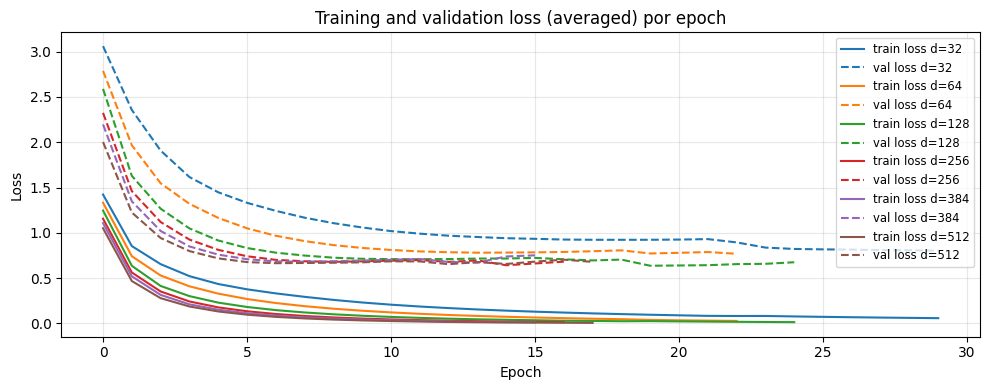

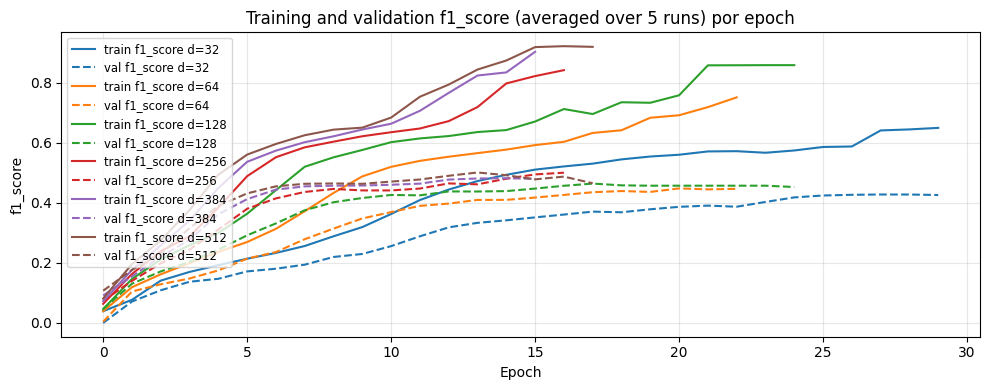

In [7]:
def model_build(model, num_classes):
    model.add(GlobalMaxPooling1D(data_format='channels_last'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model
results = provar_embeddings(model_build, preprocessed_data=data_intent_recognition, batch_size=32, epochs=30, 
                            embedding_dims=[32, 64, 128, 256, 384, 512], patience=5, runs=5)

# Balanceo de clases
Usar el class_weight en model.fit(class_weight = class_weight)

In [8]:
train_encoded_labels = data_intent_recognition['train_y']
class_weights = calculate_class_weights(train_encoded_labels)
print('Class weights:')
for class_index, weight in class_weights.items():
    print(f'{class_index}: {np.round(weight, 2)}')

Class weights:
0: 1.54
1: 2.73
2: 185.36
3: 0.56
4: 185.36
5: 1.48
6: 92.68
7: 13.24
8: 14.26
9: 185.36
10: 11.59
11: 12.36
12: 0.06
13: 12.36
14: 16.85
15: 4.03
16: 12.36
17: 0.91
18: 185.36
19: 61.79
20: 3.71
21: 92.68


-------Running class_weights=None  (5 runs)...---------


C:\Users\jiaha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  run 1/5 done | last val_loss=0.8485
  run 2/5 done | last val_loss=0.8024
  run 3/5 done | last val_loss=0.7884
  run 4/5 done | last val_loss=0.8347
  run 5/5 done | last val_loss=0.6626
Finished embedding_dim=no_class_weights  |  averaged last val_loss=0.8485
-------Running class_weights={0: 1.5446969696969697, 1: 2.7259358288770055, 2: 185.36363636363637, 3: 0.5566475566475566, 4: 185.36363636363637, 5: 1.482909090909091, 6: 92.68181818181819, 7: 13.24025974025974, 8: 14.258741258741258, 9: 185.36363636363637, 10: 11.585227272727273, 11: 12.357575757575757, 12: 0.06131777583977385, 13: 12.357575757575757, 14: 16.85123966942149, 15: 4.029644268774703, 16: 12.357575757575757, 17: 0.9131213613972234, 18: 185.36363636363637, 19: 61.78787878787879, 20: 3.707272727272727, 21: 92.68181818181819}  (5 runs)...---------
  run 1/5 done | last val_loss=0.5100
  run 2/5 done | last val_loss=0.5514
  run 3/5 done | last val_loss=0.5165
  run 4/5 done | last val_loss=0.5255
  run 5/5 done | last

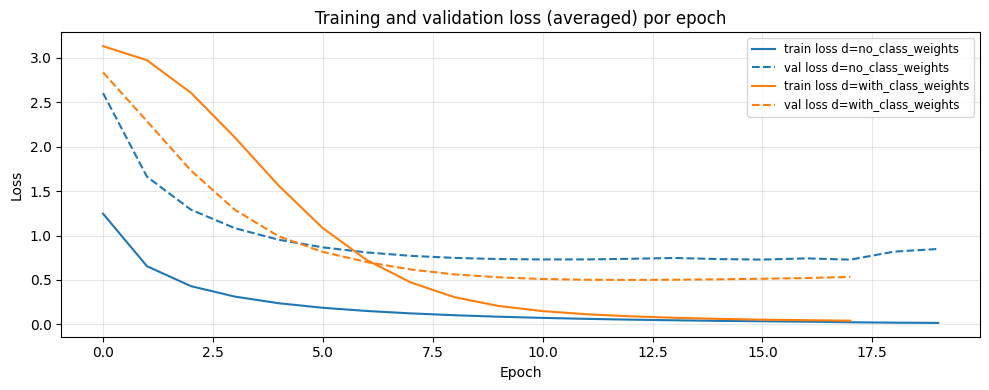

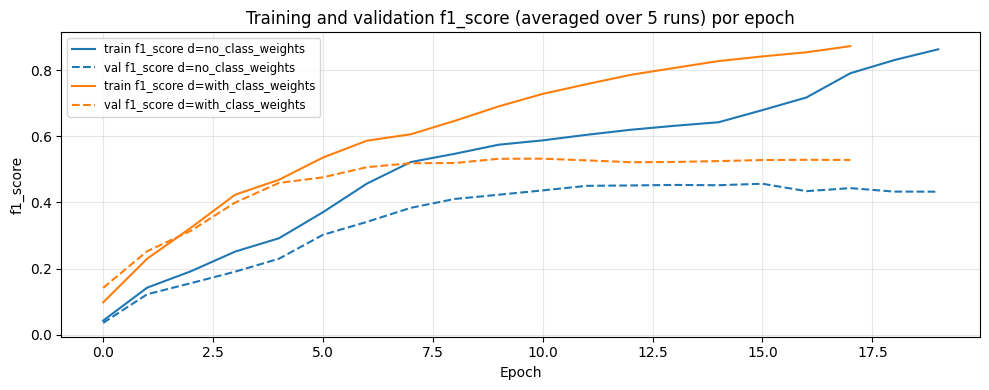

In [9]:
def model_build(num_classes, vocab_size, maxlen):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen))
    model.add(GlobalMaxPooling1D(data_format='channels_last'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

results = probar_class_weights(model_build, preprocessed_data=data_intent_recognition, batch_size=32, epochs=30, 
                               class_weights_list=[None, class_weights], patience=5, runs=5)